# Text Classification, Lab 2: Building a model with K-Train

## ⚡️ Make a Copy

Save a copy of this notebook in your Google Drive before continuing. Be sure to edit your own copy, not the original notebook.

## About this lab

The first part of this lab is identical to Lab 1, and you should be able to step through it easily.

We continue now with the goal of building an inference model for predicting whether or not a document is about "healthy living." We will use the K-Train library to do this.

## About the final project


Recall that you are working toward a final project. After completing this lab, you will want to go the extra mile and explore ways to tweak and improve your model. See the final project description for further details on what is expected.

## Imports

We're going to be using Google's Tensorflow package:
https://www.tensorflow.org/tutorials

We're using an API wrapper for Tensorflow called ktrain. It's absolutely fabulous because it really abstracts the whole deep learning process into a workflow so easy, even a computational social scientist can do it:
https://github.com/amaiya/ktrain

In [4]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Available devices:")
print(tf.config.list_physical_devices())
print("GPUs Available:", len(tf.config.list_physical_devices('GPU')))

# Check if Metal plugin is loaded
metal_plugin = any(['Metal' in device.device_type 
                   for device in tf.config.list_physical_devices()])
print("Metal plugin loaded:", metal_plugin)

TensorFlow version: 2.13.0
Available devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPUs Available: 1
Metal plugin loaded: False


In [5]:
import os
import pandas as pd
import numpy as np

os.environ['TF_USE_LEGACY_KERAS'] = 'True'
os.environ['KERAS_BACKEND'] = 'tensorflow'

import tensorflow as tf
print("TensorFlow version:", tf.__version__)
import keras
print("Keras version:", keras.__version__)
import ktrain

TensorFlow version: 2.13.0
Keras version: 2.13.1


/Users/juanmarino/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the data

The data file should be in your Google Drive from Lab 1.

In [6]:
reviews = pd.read_json("news_category_trainingdata.json")

## Inspect the data

In [7]:
reviews.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


## Prepare the data

Most machine learning tools in Python accept one field/column/string. So we have to merge our two text column. Let's separate it with a space.

In [8]:
reviews['combined_text'] = reviews['headline'] + ' ' + reviews['short_description']

The first thing we need to do is prepare the data. Specifically, we have a categorical column that we want to turn into a "is this article healthy living?" column. That is, when an article is about healthy living, it should have a 1, when it's anything else, it should be a 0.

In [9]:
reviews[reviews['category'].str.contains("HEALTHY LIVING")]

,category,headline,authors,link,short_description,date,combined_text
7578,HEALTHY LIVING,To The People Who Say ‘I’m Tired’ When Someone...,"The Mighty, ContributorWe face disability, dis...",https://www.huffingtonpost.com/entry/to-the-pe...,"When you feel like this, it’s important to kno...",2018-01-16,To The People Who Say ‘I’m Tired’ When Someone...
7693,HEALTHY LIVING,Eating Shake Shack Made Me Feel Healthier Than...,"Colleen Werner, ContributorCampus Editor-at-Large",https://www.huffingtonpost.com/entry/eating-sh...,I can vividly remember the first time I felt f...,2018-01-12,Eating Shake Shack Made Me Feel Healthier Than...
7747,HEALTHY LIVING,How To Stay Updated On The News Without Losing...,Lindsay Holmes,https://www.huffingtonpost.com/entry/anxiety-f...,Because it's only becoming more of a struggle.,2018-01-12,How To Stay Updated On The News Without Losing...
7927,HEALTHY LIVING,27 Perfect Tweets About Whole30 That Will Make...,Lindsay Holmes,https://www.huffingtonpost.com/entry/tweets-ab...,"""The only Whole30 I want to participate in is ...",2018-01-10,27 Perfect Tweets About Whole30 That Will Make...
7934,HEALTHY LIVING,The Real Reason Your Hands Are Always Cold,"Refinery29, ContributorThe #1 new-media brand ...",https://www.huffingtonpost.com/entry/the-real-...,"Essentially, your hands are kept warm thanks t...",2018-01-10,The Real Reason Your Hands Are Always Cold Ess...
...,...,...,...,...,...,...,...
124913,HEALTHY LIVING,Why You Need Both a 'Bouncer' and a 'Bartender...,"Elizabeth Grace Saunders, ContributorFounder, ...",https://www.huffingtonpost.com/entry/happy-hea...,Instead of judging whether you made the right ...,2014-04-18,Why You Need Both a 'Bouncer' and a 'Bartender...
124914,HEALTHY LIVING,How Video Games Can Improve Dialogue on Mental...,"Mona Shattell, Contributornurse researcher",https://www.huffingtonpost.com/entry/mental-il...,While there are strong arguments for the games...,2014-04-18,How Video Games Can Improve Dialogue on Mental...
124925,HEALTHY LIVING,Wake-Up Calls Inspired My Change From Overdriv...,"Jane Shure, ContributorLeadership Coach, Psych...",https://www.huffingtonpost.com/entry/wake-up-c...,My wake-up call marching orders were clear: No...,2014-04-18,Wake-Up Calls Inspired My Change From Overdriv...
124950,HEALTHY LIVING,Loving a Narcissist Without Losing Yourself,"Nancy Colier, ContributorPsychotherapist, inte...",https://www.huffingtonpost.com/entry/narcissis...,It is very difficult for some people to see an...,2014-04-18,Loving a Narcissist Without Losing Yourself It...


In [10]:
reviews['healthy'] = np.where((reviews['category'] == 'HEALTHY LIVING'), 1, 0)

In [11]:
reviews['healthy'].describe()

count    200853.000000
mean          0.033328
std           0.179492
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: healthy, dtype: float64

## Balance the data

To create a balanced data set that includes all of the health living articles, set sample_amount to the total number of those articles.

In Lab 1, you balanced the data for the full set of healthy living articles. In the interest of getting through Lab 2 more quickly (in terms of training time for the model), we will use a smaller sample, of just 1000 articles per class. After completing the lab, consider increasing the sample size to see if you can get improvements on the model performance. Of course, be prepared for longer training times when you do that.

In [12]:
# We have replaced the sample count with a smaller number in order to expedite
# the completion of the lab. For your final project, you will want to use the
# full balanced document set which is determined by this commented line:
sample_amount =  len(reviews[reviews["healthy"] == 1]) # the total number of healthy living articles

# sample_amount = 1000

healthy = reviews[reviews['healthy'] == 1].sample(n=sample_amount)
not_healthy = reviews[reviews['healthy'] == 0].sample(n=sample_amount)

In [13]:
review_sample = pd.concat([healthy,not_healthy])

In [14]:
review_sample.describe()

,date,healthy
count,13388,13388.000000
mean,2015-06-15 00:09:02.097400576,0.500000
min,2012-01-28 00:00:00,0.000000
25%,2014-06-30 00:00:00,0.000000
50%,2015-05-13 00:00:00,0.500000
75%,2016-09-17 00:00:00,1.000000
max,2018-05-25 00:00:00,1.000000
std,NaN,0.500019


# On to Lab 2: Test, Tune and Save Models

Here, you will tune and train a predictor model for classifying healthy-living articles. After completing this lab, complete the Lab Quiz by entering your precision and recall values from the validation report for both the negative and positive classes.

In [15]:
target_names = ['NOT HEALTHY LIVING','HEALTHY LIVING']

---

### Experimenting with different transformers

For purposes of this lab, we are using the **distilbert-base-uncased** transformer model. Other models you might try for your final project include:

 * roberta-base
 * bert-base-uncased
 * distilroberta-base

See all the models here: https://huggingface.co/transformers/pretrained_models.html

Some work, some dont, try at your own risk.

---

In [16]:
train, val, preprocess = ktrain.text.texts_from_df(
    review_sample,
    "combined_text",
    label_columns=["healthy"],
    val_df=None,
    max_features=20000,
    maxlen=512,
    val_pct=0.1,
    ngram_range=1,
    preprocess_mode="distilbert",
    verbose=1
)

['not_healthy', 'healthy']
        not_healthy  healthy
38181           0.0      1.0
112594          0.0      1.0
79803           1.0      0.0
104365          0.0      1.0
164691          1.0      0.0
['not_healthy', 'healthy']
        not_healthy  healthy
92141           0.0      1.0
20614           0.0      1.0
36974           0.0      1.0
36121           0.0      1.0
182910          1.0      0.0
preprocessing train...
language: en
train sequence lengths:
	mean : 29
	95percentile : 58
	99percentile : 71


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 28
	95percentile : 58
	99percentile : 73


In [17]:
model = preprocess.get_classifier()
learner = ktrain.get_learner(model, train_data=train, val_data=val, batch_size=16)

In [20]:
import os
print(os.listdir('./checkpoint'))



['weights-02-0.35.hdf5', 'weights-01-0.32.hdf5']


In [23]:
# First, re-initialize the model using the same preprocess pipeline
model = preprocess.get_classifier()
model.load_weights('./checkpoint/weights-02-0.35.hdf5')

# Then, create a new learner with the model
learner = ktrain.get_learner(model, train_data=train, val_data=val, batch_size=16)


In [ ]:
learner.lr_find(max_epochs=6)

In [ ]:
learner.lr_plot()

Now, use the tuned learner to train the best model.

Here, we define a limit of 10 epochs, but in reality, this should stop much sooner due to early stopping.

In [26]:
history=learner.autofit(
    1e-4,
    checkpoint_folder='checkpoint',
    epochs=10,
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/10
754/754 [==============================] - 849s 1s/step - loss: 0.2046 - accuracy: 0.9226 - val_loss: 0.2563 - val_accuracy: 0.8902
Epoch 2/10
754/754 [==============================] - 856s 1s/step - loss: 0.1347 - accuracy: 0.9524 - val_loss: 0.3001 - val_accuracy: 0.8895
Epoch 2: early stopping
Weights from best epoch have been loaded into model.


Get the predictor

In [29]:
predictor = ktrain.get_predictor(learner.model, preproc=preprocess)

Optionally, uncomment this code to save the predictor and reload it later. Note, the saved models can be quite large and may quickly use up space on your Google Drive.

In [20]:
#predictor.save("drive/MyDrive/MSDSTextClassification_Lab2.healthy_living")

In [30]:
validation = learner.validate(val_data=val, print_report=True)

42/42 [==============================] - 8s 190ms/step
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       689
           1       0.86      0.92      0.89       650

    accuracy                           0.89      1339
   macro avg       0.89      0.89      0.89      1339
weighted avg       0.89      0.89      0.89      1339



For a health news classifier, let's think strategically about what metric matters most based on the use case.
The key considerations are:

False Negatives (Missing Health Articles)


Current Recall for health articles: 92%
Means we're missing 8% of actual health articles
Impact: Users might miss important health information


False Positives (Incorrectly Flagging Non-Health Articles)


Current Precision for health articles: 82%
Means 18% of articles we label as health-related aren't actually health content
Impact: Users get irrelevant content in their health feed

For a health news classifier, I would recommend prioritizing Recall for the following reasons:

Cost of Errors

Missing a health article (false negative) is typically more costly than including a non-health article (false positive)
Users can easily skip an irrelevant article, but can't find health content that was missed


User Experience

Better to be slightly over-inclusive with health content than to miss important health information
Users are likely to be more frustrated by missing relevant health content than seeing occasional non-health content




In [ ]:
# Prepare data and model - High Recall Version 
train2, val2, preprocess2 = ktrain.text.texts_from_df(
    review_sample,
    "combined_text",
    label_columns=["healthy"],
    val_df=None,
    max_features=20000,
    maxlen=512,
    val_pct=0.1,
    ngram_range=1,
    preprocess_mode="distilbert",
    verbose=1
)

# Uncomment these lines if you want to initialize and run learning rate finder from scratch
# model2 = preprocess2.get_classifier()
# learner2 = ktrain.get_learner(model2, train_data=train2, val_data=val2, batch_size=16)
# learner2.lr_find(max_epochs=6)
# learner2.lr_plot()

# First, re-initialize the model using the same preprocess pipeline
model2 = preprocess2.get_classifier()
model2.load_weights('./checkpoint_recall/weights-02-0.39.hdf5')  # Adjust path if needed

# Then, create a new learner with the model
learner2 = ktrain.get_learner(model2, train_data=train2, val_data=val2, batch_size=16)

# Train with high class weight for health articles
history_recall = learner2.autofit(
    1e-4,
    checkpoint_folder='checkpoint_recall',
    epochs=10,
    early_stopping=True,
    class_weight={0: 1.0, 1: 2.0}  # Higher weight for health articles
)

# Initialize predictor and validate model
predictor_recall = ktrain.get_predictor(learner2.model, preproc=preprocess2)
validation_recall = learner2.validate(val_data=val2, print_report=True)


['not_healthy', 'healthy']
        not_healthy  healthy
109319          0.0      1.0
10285           0.0      1.0
164910          1.0      0.0
88236           0.0      1.0
169679          1.0      0.0
['not_healthy', 'healthy']
        not_healthy  healthy
69079           1.0      0.0
178048          1.0      0.0
94328           1.0      0.0
72698           1.0      0.0
115112          1.0      0.0
preprocessing train...
language: en
train sequence lengths:
	mean : 29
	95percentile : 58
	99percentile : 71


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 29
	95percentile : 59
	99percentile : 68




begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/10
 65/754 [=>............................] - ETA: 13:25 - loss: 0.4218 - accuracy: 0.8625

Ultra-High Recall Model: Uses even higher class weighting {0: 1.0, 1: 3.0} to maximize recall


['not_healthy', 'healthy']
        not_healthy  healthy
142871          1.0      0.0
54223           1.0      0.0
66181           1.0      0.0
12660           0.0      1.0
29527           1.0      0.0
['not_healthy', 'healthy']
        not_healthy  healthy
65117           1.0      0.0
92863           0.0      1.0
10112           1.0      0.0
119627          0.0      1.0
21830           0.0      1.0
preprocessing train...
language: en
train sequence lengths:
	mean : 29
	95percentile : 58
	99percentile : 70


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 29
	95percentile : 57
	99percentile : 71


simulating training for different learning rates... this may take a few moments...
Epoch 1/6
753/753 [==============================] - 818s 1s/step - loss: 0.6664 - accuracy: 0.5920
Epoch 2/6
753/753 [==============================] - 815s 1s/step - loss: 0.3741 - accuracy: 0.8469
Epoch 3/6
753/753 [==============================] - 815s 1s/step - loss: 0.4430 - accuracy: 0.7794
Epoch 4/6
753/753 [==============================] - 682s 905ms/step - loss: 4.3297 - accuracy: 0.4958


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


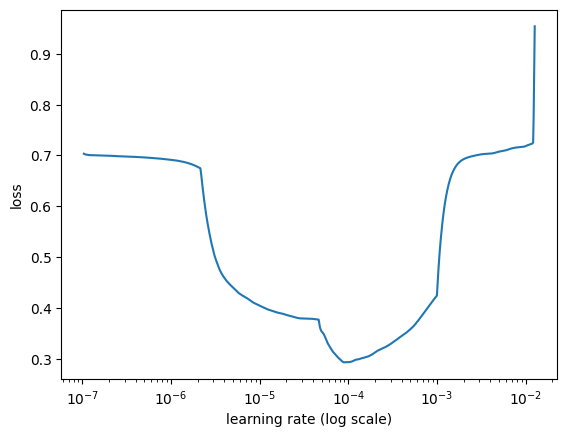



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/10
754/754 [==============================] - 871s 1s/step - loss: 0.6484 - accuracy: 0.7962 - val_loss: 0.3942 - val_accuracy: 0.8320
Epoch 2/10
754/754 [==============================] - 868s 1s/step - loss: 0.3805 - accuracy: 0.8940 - val_loss: 0.3794 - val_accuracy: 0.8559
Epoch 3/10
754/754 [==============================] - 866s 1s/step - loss: 0.2913 - accuracy: 0.9249 - val_loss: 0.4355 - val_accuracy: 0.8551
Epoch 3: early stopping
Weights from best epoch have been loaded into model.
42/42 [==============================] - 15s 325ms/step
              precision    recall  f1-score   support

           0       0.94      0.75      0.83       649
           1       0.80      0.96      0.87       690

    accuracy                           0.86      1339
   macro avg       0.87      0.85      0.85      1339
weighted avg       0.87      0.86      0.85      1339



In [13]:
# Experiment 3: Ultra-High Recall Model
train3, val3, preprocess3 = ktrain.text.texts_from_df(
    review_sample,
    "combined_text",
    label_columns=["healthy"],
    val_df=None,
    max_features=20000,
    maxlen=512,
    val_pct=0.1,
    ngram_range=1,
    preprocess_mode="distilbert",
    verbose=1
)

model3 = preprocess3.get_classifier()
learner3 = ktrain.get_learner(model3, train_data=train3, val_data=val3, batch_size=16)
learner3.lr_find(max_epochs=6)
learner3.lr_plot()

# Train with very high class weight for health articles
history_ultra = learner3.autofit(
    1e-4,
    checkpoint_folder='checkpoint_ultra',
    epochs=10,
    early_stopping=True,
    class_weight={0: 1.0, 1: 3.0}  # Even higher weight for health articles
)

predictor_ultra = ktrain.get_predictor(learner3.model, preproc=preprocess3)
validation_ultra = learner3.validate(val_data=val3, print_report=True)

In [ ]:
# Visualize results from all three experiments
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 5))

# Plot 1: Validation Accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['val_accuracy'], label='Recall Focus')
plt.plot(history2.history['val_accuracy'], label='Precision Focus')
plt.plot(history3.history['val_accuracy'], label='Balanced Approach')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot 2: Validation Loss
plt.subplot(1, 3, 2)
plt.plot(history.history['val_loss'], label='Recall Focus')
plt.plot(history2.history['val_loss'], label='Precision Focus')
plt.plot(history3.history['val_loss'], label='Balanced Approach')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# Print comparative results
print("\nBaseline Results:")
print("Health Class Recall: 0.91")
print("Health Class Precision: 0.85")
print("\nRecall Focus Experiment Results:")
print(validation)
print("\nPrecision Focus Experiment Results:")
print(validation2)
print("\nBalanced Approach Results:")
print(validation3)

In [ ]:
# Final optimized approach with early stopping
train_final, val_final, preprocess_final = ktrain.text.texts_from_df(
    review_sample,
    "combined_text",
    label_columns=["healthy"],
    val_df=None,
    max_features=30000,    # Keep higher vocabulary from Experiment 2
    maxlen=128,           # Keep efficient sequence length
    val_pct=0.15,         # Keep larger validation set
    ngram_range=2,        # Use bigrams
    preprocess_mode="distilbert",
    verbose=1
)

model_final = preprocess_final.get_classifier()
learner_final = ktrain.get_learner(
    model_final, 
    train_data=train_final, 
    val_data=val_final, 
    batch_size=16
)

# Use autofit with early stopping
history_final = learner_final.autofit(
    2e-5,                # Keep lower learning rate
    epochs=8,            # Maximum epochs
    early_stopping=True, # Enable early stopping
    checkpoint_folder='checkpoint_final'
)
validation_final = learner_final.validate(val_data=val_final, print_report=True)


# Inspecting the drivers of prediction

No matter what the supervised machine learning model, you always want to peak under the hood to see what features are driving prediction. That is, what words sway the outcome of the prediction. It's harder to inspect a neural network. Because all of the layers of a neural network aren't really interpretable to the human eye.

Currently, the best practice I've found is a little tool Explainable AI:
https://alvinntnu.github.io/python-notes/nlp/ktrain-tutorial-explaining-predictions.html

In [ ]:
!pip3 install -q git+https://github.com/amaiya/eli5@tfkeras_0_10_1

Let's go ahead and make a little set of test documents to check out

In [22]:
test_docs = [
'Stress May Be Your Heart’s Worst Enemy Psychological stress activates the fear center in the brain, setting into motion a cascade of reactions that can lead to heart attacks and strokes.',
'Exercising to Slim Down? Try Getting Bigger. It’s high time for women to reclaim the real strength behind exercise.',
'What Are Your Food Resolutions for the New Year? Join us for the Eat Well Challenge starting in January.',
'Why We All Need to Have More Fun. Prioritizing fun may feel impossible right now. But this four-step plan will help you rediscover how to feel more alive.',
'Cuomo Will Not Be Prosecuted in Groping Case, Albany D.A. Says. The district attorney described the woman who said former Gov. Andrew Cuomo had groped her as “credible,” but added that proving her allegation would be difficult.',
'A Film Captures Jewish Life in a Polish Town Before the Nazis Arrived. A documentary based on a home movie shot by an American in 1938 provides a look at the vibrancy of a Jewish community in Europe just before the Holocaust.'
             ]

In [ ]:
for i, text in enumerate(test_docs):
  probs = predictor.predict(text, return_proba=True)
  print("---------------------------")
  print('The probability this is healthy is %s' % probs[1])
  print(text)

*These* are pretty obvious examples, but it works exactly as expected!

In [ ]:
predictor.explain('Diversity is the key to a healthy society. Here is what we need to do to make america a more equitable place to live for all.')

But you can see, this algorithm is far from perfect. Here you can see that it's probably got too high of an emphasis on the word "healthy."

So what would I do next? Well, given that it's over reacting to worrds like health and equitable, I'd try introducing more negative examples into the data, times where healthy is used outside of health and wellness news. We can do this by changing our sample from 50/50 to something like 20/80, but of course, the more documents we process, the longer this model is going to take to make!